**BGP Measurements Project - Jupyter Notebook**

NOTE: There is an associated PDF Project Description for the BGP Measurements project.
That document has instructions on how to install and use Jupyter Notebooks.
The project description also has important information about how to submit and warnings about plagiarism. **Please be
sure to read through the project description before starting on this project**

In [1]:
# Import the pybgpstream library and any graphing library here

import pybgpstream
import os
from datetime import datetime
from matplotlib import pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
from collections import defaultdict
from itertools import groupby

**Task 1: Historic measurement - Prefixes and ASes growth over time** 

**A. Plots: a) Read Data** Read in / Process /Filter. Write code to process the data for all of the .cache files in the rib_files directory
with PyBGPstream.

You will need to set the stream data_interface to “single file” with the following command:
`pybgpstream.BGPStream(data_interface="singlefile")`


After the `data_interface` has been set, make sure its interface options are set with:
`stream.set_data_interface_option("singlefile", "rib-file", filepath)`
where `filepath` is a placeholder for a specific cache file.

In [2]:
# Replace the contents of this cell with your code for Task 1 part A
#calculate run time
start = datetime.now()

date_ases = defaultdict(set)
date_prefixes = defaultdict(set)
date_ases_prefixes = {}
date_ases_path = {}
rb_filename = []

for file in os.listdir("rib_files"):
    rb_filename.append(file)
rb_filename.sort()

for file in rb_filename:
    stream = pybgpstream.BGPStream(data_interface = "singlefile")
    f = os.path.abspath("rib_files/" + file)
    if file.endswith(".cache"):
        stream.set_data_interface_option("singlefile", "rib-file", f)
    for ele in stream:
        time = datetime.fromtimestamp(ele.time).date()
        prefix = ele.fields["prefix"]
        original_as = ele.fields["as-path"].split(" ")[-1]
        path = ele.fields["as-path"].split(" ")
        
        #Add ASes from the path to the dict:set
        for ases in path:
            #Check if there is a set within the path, if there is iterate through to add to the dict:set
            if isinstance(ases, set):
                for item in ases:
                    date_ases[time].add(item)
            else:
                date_ases[time].add(ases)
        date_prefixes[time].add(prefix)
            
        #To answer 2 and 3
        #date_ases_prefixes, structure {date:{ases:{prefixes}}}
        if time in date_ases_prefixes:
            if original_as in date_ases_prefixes[time]:
                date_ases_prefixes[time][original_as].add(prefix)
            else:
                date_ases_prefixes[time][original_as] = {prefix}
        else:
            date_ases_prefixes[time] = {original_as:{prefix}}
            
        #For task 2
        #date_ases_path, structure {date:{ases:shortest path length}}
        rm_dup_path = [k for k, g in groupby(path)]
        path_length = len(rm_dup_path)
            
        if time in date_ases_path:
            if original_as in date_ases_path[time]:
                current_length = date_ases_path[time][original_as]
                if path_length < current_length: date_ases_path[time][original_as] = path_length
            else: 
                date_ases_path[time][original_as] = path_length
        else:
            date_ases_path[time] = {original_as:path_length}
#calculate runtime
end = datetime.now()
print(f"Runtime of the program is {end - start}")

Runtime of the program is 0:11:48.917347


**A. Plots: b) Plot Graphs** Using the data from part A, plot a line graph that shows the number of total unique prefixes over time.

1. The X-axis should represent time (e.g. January 2013, January 2014 and so on)

2. The Y-axis represents the number of unique prefixes within the specific time period (e.g. January 2013, January 2014 and so on).

3. Repeat steps 1 and 2 for the unique number of ASes over time.

4. Make sure each graph and its axes are clearly labeled.

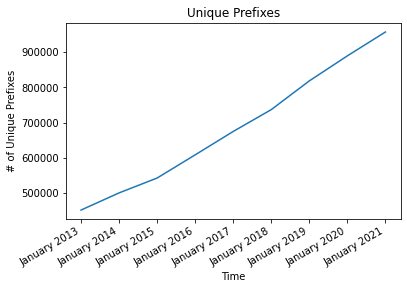

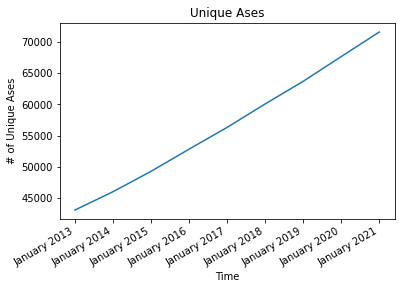

Top 10 growth (format: (AS, Percentage:))
[('26484', 180100.0), ('21859', 82400.0), ('132203', 78500.0), ('62240', 76400.0), ('35913', 75000.0), ('134705', 61600.0), ('47331', 52183.333333333336), ('58952', 30400.0), ('23470', 30200.0), ('45090', 29842.857142857145)]


In [3]:
# Replace the contents of this cell with your code for Task 1 part B
x = []
y_prefixes = []
y_ases = []
dates = []

for key in date_ases:
    x.append(key)
    
x = sorted(x)

for date in x:
    y_ases.append(len(date_ases[date]))
    y_prefixes.append(len(date_prefixes[date]))
    dates.append("January " + str(date.year))

#plt.plot(x_prefixes, y_prefixes)
plt.plot(dates, y_prefixes)
plt.title("Unique Prefixes")
plt.xlabel("Time")
plt.ylabel("# of Unique Prefixes")
plt.gcf().autofmt_xdate()
plt.show()
    
#plt.plot(x_ases, y_ases)
plt.plot(dates, y_ases)
plt.title("Unique Ases")
plt.xlabel("Time")
plt.ylabel("# of Unique Ases")
plt.gcf().autofmt_xdate()
plt.show()

#FOR 2
#Go into the date_ases_prefixes dictionary
#Look into each origin ASes and get the total number of prefixes for that AS during the year
check = {}
for key in x:
    for ases_key in date_ases_prefixes[key]:
        count = len(date_ases_prefixes[key][ases_key])
        if ases_key in check:
            check[ases_key].append(count)
        else:
            check[ases_key] = [count]
#print(len(check))
#print(check)

#FOR 3
#Go into the check directory since the directory contains all ASes and the total number of prefixes in year order
#Grab the number from last item (year) and subtract by number of the first item (year)
#Divide by the bnumber of the first item (year) and place it into a separate growth check dictionary
#Sort the growth check dictionary by items and return the top 10 growth by percentages
growth_check = {}
less = 0
equal = 0
more = 0
for key in check:
    first = check[key][0]
    last = check[key][-1]
    growth = last - first
    growth_rate =  (growth / first) * 100
    growth_check[key] = growth_rate
    if growth_rate > 0: more += 1
    elif growth_rate < 0: less += 1
    else: equal += 1
#print(len(growth_check)) 
#print(less) #shows number of ASes with negative percentage growth
#print(equal) #shows number of ASes with no growth
#print(more) shows number of ASes with positive percentage growth
    
sort_check = sorted(growth_check.items(), key=lambda x: x[1], reverse=True) 
print("Top 10 growth (format: (AS, Percentage:))")
print(sort_check[0:10])        

**B.**
In the following cells answer the following:

1. What do you notice about the overall trend of the two graphs?
(e.g. how would you describe the overall growth of prefixes, overall growth of ASes)?

<span style="color:red">I noticed that the growth trend between the two graphs is linear and the number keeps increasing overtime. As the number of prefixes continue to increase linearly over time, the number of ASes also grew in a very similar fashion, which is an sign that there is a positive correlation between the two growth rate.</span>

2. For each origin AS examine the total unique prefixes they advertise over time.
What is the trend that you notice for most origin ASes?

<span style="color:red">For most/majority origin ASes, the trend shows the total unique prefixes that they advertise have actually remain consistent over time. For some origin ASes, the total unique prefixes that they advertise have increase over time.</span>


3. Locate the origin ASes that experience the largest growth of advertised unique prefixes over time.
To calculate the growth for an AS, identify the first and the last snapshot where the AS appeared in the dataset.
Calculate the percentage increase of the advertised prefixes, using the first and the last snapshot. Report the top 10 origin ASes.


<span style="color:red">(Please refer to my code to see the commented out portion to see how I found my top 10 origin ASes) MY TOP TEN:</span>
<ol>
    <li>'26484'</li> 
    <li>'21859'</li> 
    <li>'132203'</li> 
    <li>'62240'</li> 
    <li>'35913'</li> 
    <li>'134705'</li> 
    <li>'47331'</li> 
    <li>'58952'</li> 
    <li>'23470'</li> 
    <li>'45090'</li>
</ol>

**Task 2. Historic measurement - AS-path length evolution over time**

For this task you should use the same data collected as in Task 1.
For each origin AS, for each year, compute the shortest AS path length.
To compute the shortest path lengths for each path consider each AS only once
(by removing duplicate entries of the same AS) and count the AS hops in the path.

**A**. To see how the shortest path lengths are distributed across the origin ASes create an
ECDF as follows: For each month, plot an ECDF of the shortest AS path lengths across all origin ASes. You should have
one ECDF for January 2013, one ECDF for January 2014, and so on. You should overlay multiple lines on one chart.

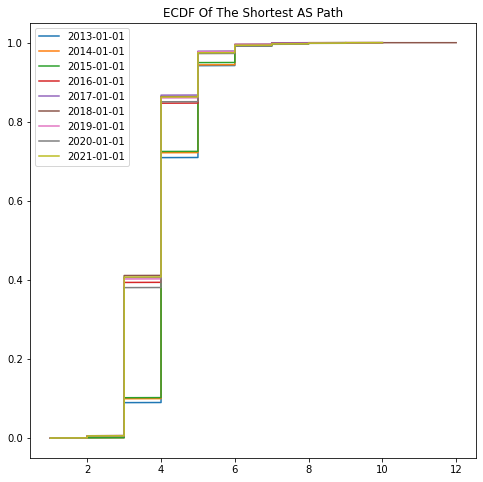

Top 5 Original ASes per year, format (orginal AS, path length)
2013-01-01
[('45554', 10), ('52906', 9), ('53036', 9), ('47237', 9), ('50873', 9)]
2014-01-01
[('50483', 10), ('51979', 9), ('56369', 9), ('131361', 9), ('41800', 9)]
2015-01-01
[('44153', 9), ('47668', 9), ('472', 9), ('474', 9), ('477', 9)]
2016-01-01
[('27817', 10), ('50139', 9), ('56749', 8), ('58216', 8), ('61668', 8)]
2017-01-01
[('58216', 9), ('28976', 9), ('3263', 9), ('56660', 9), ('58250', 9)]
2018-01-01
[('62793', 12), ('1501', 10), ('60256', 9), ('12697', 9), ('59526', 9)]
2019-01-01
[('1501', 10), ('267429', 10), ('58267', 9), ('56703', 9), ('61248', 9)]
2020-01-01
[('61362', 10), ('18155', 10), ('145', 10), ('57461', 10), ('202570', 10)]
2021-01-01
[('202570', 10), ('1501', 10), ('60663', 10), ('207281', 10), ('1565', 9)]


In [4]:
# Replace the contents of this cell with your code for Task 2 part A
plt.figure(figsize=(8,8))
for date in x:
    shortest_path = []
    for ases in date_ases_path[date]:
        shortest_path.append(date_ases_path[date][ases])
    ecdf = ECDF(shortest_path)
    plt.plot(ecdf.x, ecdf.y)
    plt.title("ECDF Of The Shortest AS Path")
plt.legend(x)
plt.show()

#FOR 2
#Go into the date_ases_path dictionary
#Sort the date_ases_path[date] by items (path length) in descending order
#Grab the top five for each year
print("Top 5 Original ASes per year, format (orginal AS, path length)")
check = {}
for date in x:
    check[date] = []
    count = 0
    sort_check = sorted(date_ases_path[date].items(), key=lambda x: x[1], reverse=True)
    for top in sort_check:
        if count == 5: break
        else:
            check[date].append(top)
            count += 1    
for date in check:
    print(date)
    print(check[date])   

**B.**
In the text/markdown fields after your code cell in the Notebook, answer these 	questions:

1. What is the trend of the AS path lengths progressing over time? Justify your answer with the data you collected – be specific.

<span style="color:red">All graphs have a "staircases" trend. When examine the data closely, I can see the percentage for the number of origin ASes with certain shortest AS path lengths have grown over time. For example, path length 3 have remained near 0.1 from 2013 to 2015, and increased close to 0.4 from 2016 to 2021. Another example, path length 4 have remained near 0.7 from 2013 to 2015 and increased to close to 0.9 from 2016 to 2021. However, this growth trend actually dies down as the AS path length increases. When examining the number of origin ASes with shortest AS path lengths greater than 5, the percentage of increase begins to go down and stop/ dies when the AS path lengths passes around 10.  </span>

2. From the shortest paths you have already computed, which are the top 5 origin ASes with the longest paths per month,
and do these ASes stay the same as time progresses?

<span style="color:red"> (Please refer to my code to see the commented out portion to see how I found my top 5 origin ASes over time) These ASes don't remain the same as time progresses. TOP 5 origin ASes with the longest paths per year in the format of (AS, path length):</span>
<h3>2013-01-01</h3>
('45554', 10)
('52906', 9)
('53036', 9)
('47237', 9)
('50873', 9)
<h3>2014-01-01</h3>
('50483', 10)
('51979', 9)
('56369', 9)
('131361', 9)
 ('41800', 9)
<h3>2015-01-01</h3>
('44153', 9)
('47668', 9)
('472', 9)
('474', 9)
('477', 9)
<h3>2016-01-01</h3>
('27817', 10)
('50139', 9)
('56749', 8)
('58216', 8)
('61668', 8)
<h3>2017-01-01</h3>
('58216', 9)
('28976', 9)
('3263', 9)
('56660', 9)
('58250', 9)
<h3>2018-01-01</h3>
('62793', 12)
('1501', 10)
('60256', 9)
('12697', 9)
('59526', 9)
<h3>2019-01-01</h3>
('1501', 10)
('267429', 10)
('58267', 9)
('56703', 9)
('61248', 9)
<h3>2020-01-01</h3>
('61362', 10)
('18155', 10)
('145', 10)
('57461', 10)
('202570', 10)
<h3>2021-01-01</h3>
('202570', 10)
('1501', 10)
('60663', 10)
('207281', 10)
('1565', 9)

**Task 3. Blackholing events**

Have a look at :
What is a Blackhole event? https://tools.ietf.org/html/rfc7999#section-2  

Example Blackhole event: https://blog.apnic.net/2019/03/22/bgp-communities-a-weapon-for-the-internet-part-2/  

**A.**
Locate the directory update_files_blackholing included with this assignment. This is a collection of BGP Updates from
January 2, 2021 5:00 to January 2, 2021 9:00. As in Task 1B, write code to process all of the update cache files.

In [ ]:
# Replace the contents of this cell with your code for Task 3 part A
blackholing= {}
bh_filename = []

for file in os.listdir("update_files_blackholing"):
    bh_filename.append(file)
bh_filename.sort()

for file in bh_filename:
    stream = pybgpstream.BGPStream(from_time="2021-01-02 05:00:00 UTC", until_time="2021-01-02 09:00:00 UTC", 
                                   data_interface = "singlefile", filter = "ipversion 4")
    f = os.path.abspath("update_files_blackholing/" + file)
    if file.endswith(".cache"):
        stream.set_data_interface_option("singlefile", "upd-file", f)
    for ele in stream:
        eltype = ele.type
        time = datetime.fromtimestamp(ele.time)
        exist = False
        
        try:
            tracking_key = (ele.fields["prefix"], ele.peer_address)
        except KeyError:
            continue
            
        try:
            community = ele.fields["communities"]
        except KeyError:
            community = None
        
        #Check if community tag contains RBTH (666)
        if community is not None:
            for tag in community:
                if tag.split(":")[1] == "666": exist = True
            
        if tracking_key not in blackholing:
            blackholing[tracking_key] = [[eltype, time, exist]]
        else:
            blackholing[tracking_key].append([eltype, time, exist])

**B.**
Identify the IPV4 prefixes that are tagged with at least one Remote Triggered Blackholing (RTBH) community. Measure the
time duration of the RBTH event. This is the time elapsed between the Announcement and Withdrawal of the IPV4 prefix
tagged with the RTBH community. We are interested only in non-zero durations. For example, for a stream A1 A2
A3_RTBH_tagged W1 W2 W3 W4, compute the A3_RTBH_tagged - W1 per prefix, and per peer IP.

In [ ]:
# Replace the contents of this cell with your code for Task 3 part B
rbth_check = {}

for key in blackholing:
    if len(blackholing[key]) == 1:
        continue
    else:
        sorted_bh = sorted(blackholing[key], key=lambda x: x[1])
        i = 0
        j = 1
        rbth_check[key] = []
        while j < len(sorted_bh):
            current_a = sorted_bh[i][0]
            current_a_time = sorted_bh[i][1]
            current_a_tag = sorted_bh[i][2]
            next_a = sorted_bh[j][0]
            next_a_time = sorted_bh[j][1]
            if current_a == "A" and next_a == "W" and current_a_tag == True:
                dif = (next_a_time - current_a_time).total_seconds()
                rbth_check[key].append(dif)
            i += 1
            j += 1

**C.**
Plot an ECDF of the event durations.

In [ ]:
#ECDF blackholing durations
bh_prefix = []
bh_durations = []

for key in rbth_check:
    if rbth_check[key]: bh_prefix.append(key)

for key in rbth_check:
    for time in rbth_check[key]:
        if time > 0: bh_durations.append(time)
bh_durations.sort()
bh_ecdf = ECDF(bh_durations)
plt.plot(bh_ecdf.x, bh_ecdf.y, drawstyle = "steps-post")
plt.title("Blackholing Events")
plt.show()

#Number of prefixes identified
print("Number of prefixes identified")
print(len(bh_prefix))

#Number of RTBH events identify for identified prefixes
print("Number of RTBH events identified")
print(len(bh_durations))
print("RTBH durations")
print(bh_durations)

**D.**
In the text/markdown fields after your code cell in the Notebook, answer these questions:

1. How many prefixes did you identify?

<span style="color:red">1</span>


2. How many RTBH events did you identify for all your identified prefixes?

<span style="color:red">4</span>



**Task 4. A/W Events**

**A.** Locate the directory `update_files_pt4` included with this assignment. This is a collection of BGP Updates for a two-hour
window starting at 21-01-02 05:10. As with previous tasks, you will need to write code to process all of the cache files.
For this section, you will measure the duration of Announcement Withdrawal (AW) events for all IPV4 prefixes.

To do this, you will want to keep track of the tuples <advertised prefix IPV4 – peerIP>, and for each tuple measure the
durations of AW events. For example, for a stream A1 A2 A3 W1 W2 W3 W4, compute the A3-W1 per prefix, and per peer IP.

In [ ]:
# Replace the contents of this cell with your code for Task 4 part A
tracking = {}
t4_filename = []

for file in os.listdir("update_files_pt4"):
    t4_filename.append(file)
t4_filename.sort()

for file in t4_filename:
    stream = pybgpstream.BGPStream(from_time="2021-01-02 05:10:00 UTC", until_time="2021-01-02 07:10:00 UTC", 
                                   data_interface = "singlefile", filter = "ipversion 4")
    f = os.path.abspath("update_files_pt4/" + file)
    if file.endswith(".cache"):
        stream.set_data_interface_option("singlefile", "upd-file", f)
    for ele in stream:
        time = datetime.fromtimestamp(ele.time)
        eltype = ele.type
        
        try:
            tracking_key = (ele.fields["prefix"], ele.peer_address)
        except KeyError:
            continue
            
        if tracking_key not in tracking:
            tracking[tracking_key] = [[eltype, time]]
        else:
            tracking[tracking_key].append([eltype, time])
                        
shortest_tracking = {}
new_tracking = []

for key in tracking:
    if len(tracking[key]) == 1:
        continue
    else:
        sorted_tracking = sorted(tracking[key], key=lambda x: x[1])
        i = 0
        j = 1
        while j < len(sorted_tracking):
            current_a = sorted_tracking[i][0]
            current_a_time = sorted_tracking[i][1]
            next_a = sorted_tracking[j][0]
            next_a_time = sorted_tracking[j][1]
            if current_a == "A" and next_a == "W":
                dif = (next_a_time - current_a_time).total_seconds()
                if dif > 0:
                    new_tracking.append(dif)
                    if key not in shortest_tracking:
                        shortest_tracking[key] = dif
                    else: 
                        if dif < shortest_tracking[key]:
                            shortest_tracking[key] = dif
            i += 1
            j += 1
            
sort_shortest = sorted(shortest_tracking.items(), key=lambda x: x[1])

#To get the top 10 shortest AW duration
#print(new_tracking[0:10])

#ECDF of AW duration
ecdf = ECDF(new_tracking)
plt.plot(ecdf.x, ecdf.y)
plt.title("A/W Events")
plt.show()

#Print all shortest AW duration tuples
print("All shortest AW durations tuples with 1 second duration")
for pair in sort_shortest:
    if pair[1] == 1:
        print(pair)
    

**B.**
In the text/markdown fields after your code cell in the Notebook, answer these questions.
Please note that we are only interested in non-zero durations.


1. Which are the tuples <advertised prefix IPV4 – peerIP> with the top 10 shortest AW durations?

<span style="color:red">Please refer to the above print statement for other shortest AW durations tuples...My top 10 shortest AW durations tuples:</span>
<ol>
    <li>('67.211.53.0/24', '202.249.2.185')</li>
    <li>('161.217.67.0/24', '202.249.2.185')</li> 
    <li>('99.194.200.0/22', '202.249.2.185')</li> 
    <li>('216.238.254.0/23', '202.249.2.185')</li> 
    <li>('84.205.66.0/24', '202.249.2.185')</li>
    <li>('208.81.64.0/24', '202.249.2.185')</li> 
    <li>('130.137.99.0/24', '202.249.2.185')</li>
    <li>('130.137.105.0/24', '202.249.2.185')</li>
    <li>('63.92.224.0/19', '202.249.2.185')</li>
    <li>('63.92.224.0/20', '202.249.2.185')</li>
</ol>



2. What are the corresponding durations?

<span style="color:red">The corresponding durations are all 1 second.</span>